<a id="intro"></a>

## 1. Introduction

Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The UCI Machine Learning Repository has made this dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail".

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Transactional data is widely used in ecommerce, and is suitable for various types of analysis, include cohort analysis and RFM analysis.


[back to top](#table_of_contents)

<a id="table_of_contents"></a>
### Table of Contents

1. [Introduction](#intro)
    * 1.1 [Problem Statement](#problem_statement)
    * 1.2 [Data Gathering](#data_gathering)
2. [Setup](#setup)
    * 2.1 [Importing the Data](#import)
3. [General](#general)
    * 3.1 [Shape](#shape)
    * 3.2 [Statistics](#stats)
    * 3.3 [Hygiene](#hygiene)
4. [Cohort Analysis](#cohort)
    * 4.1 [Data Cleaning](#data_cleaning)
    * 4.2 [Invoiceno Test](#invoiceno)
    * 4.3 [Quantity/Price Test](#quantityprice)
    * 4.4 [Completing Variables](#iddesc)
    * 4.5 [Creating New Variables](#creating)
    * 4.6 [Calculate Absolute Cohorts and Retention](#retention)
    * 4.7 [Calculate Average Price](#price)
    * 4.8 [Calculate Average Quantity](#quantity)
5. [Cohort Analysis Visualization](#eda)
6. [RFM Analysis](#rfm)
    * 6.1 [RFM Scoring](#rfm_scoring)
    * 6.2 [RFM Profiling](#rfm_profiling)
7. [Segmentation](#segmentation)
    * 7.1 [K-Means](#kmeans)
    * 7.2 [Choosing K](#choosing_k)
    * 7.3 [Scree Plot](#screeplot)
    * 7.4 [K Clusters](#k_clusters)
    * 7.5 [Snake Plots](#snake_plots)
    * 7.6 [Importance Scores](#importance)

<a id="problem_statement"></a>

## 1.1 Problem Statement

Who are our loyal customers?

What is the profile of our customers most likely to churn? 

[back to top](#table_of_contents)

<a id="data_gathering"></a>

## 1.2 Data Gathering

A copy of the dataset can be found [here](https://github.com/csanry/machinelearning/blob/main/ecomm_rfm/DATA/ecommerce.csv)

[back to top](#table_of_contents)

<a id="setup"></a>

## 2. Setup

#### Packages required 
* Data manipulation 
* Visualization 
* Modelling 
* Validation 

[back to top](#table_of_contents)

In [1]:
# Manipulation  
import numpy as np 
import pandas as pd
import re
import datetime as dt

# Visualization 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

# ignore warnings 
# import warnings 
# warnings.filterwarnings('ignore')

# Modelling 
from sklearn.cluster import KMeans

# Preprocessing 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
# For feature selection
from sklearn.feature_selection import SelectFromModel, RFECV

# Validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, ShuffleSplit, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, plot_confusion_matrix

import os
# os.getcwd()

['#4878d0', '#ee854a', '#6acc64', '#d65f5f', '#956cb4', '#8c613c', '#dc7ec0', '#797979', '#d5bb67', '#82c6e2']


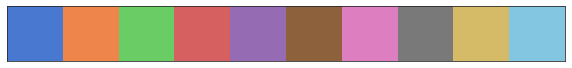

In [2]:
# Set styles 
%matplotlib inline

# mpl.style.use('ggplot')
pd.set_option('display.max_rows', 1000)
sns.set_style('white')
sns.set_palette('muted')
pylab.rcParams['figure.figsize'] = 16, 10
background_color = '#f6f5f5'
col_blue = '#4878d0'
col_orange = '#ee854a'

# Colour palette hex references 
pal = sns.color_palette('muted')
sns.palplot(pal)
print(pal.as_hex())

<a id = 'import'></a>
## 2.1 Importing the Data

[back to top](#table_of_contents)

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/csanry/datasets/main/ecommerce.csv', encoding = 'ISO-8859-1')

<a id="general"></a>

## 3. General 

#### Notes from the initial familiarization of the dataset 

* Dataset has 5 categorical variables: invoiceno, stockcode, description, customerid, country
* Dataset has 3 continuous variables: quantity, invoicedate, unitprice
* Dataset has 541,909 rows and 8 columns

[back to top](#table_of_contents)

<a id="shape"></a>
## 3.1 Shape

[back to top](#table_of_contents)

In [4]:
print(f'Dataset has {df.shape[0]} rows and {df.shape[1]} columns')

Dataset has 541909 rows and 8 columns


<a id='stats'></a>

## 3.2 Statistics 

[back to top](#table_of_contents)

In [5]:
# Familiarization 
print(df.info())

# note that minimum values of price and quantity are negative 
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


<a id = 'hygiene'></a>

## 3.3 Hygiene 

* Convert column names to lowercase
* Convert date to datetime format

[back to top](#table_of_contents)

In [6]:
# Convert columns names to lowercase
df.columns = [c.lower() for c in df.columns]    
df.columns

Index(['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate',
       'unitprice', 'customerid', 'country'],
      dtype='object')

In [7]:
display(df['invoicedate'].values)

array(['12/1/2010 8:26', '12/1/2010 8:26', '12/1/2010 8:26', ...,
       '12/9/2011 12:50', '12/9/2011 12:50', '12/9/2011 12:50'],
      dtype=object)

In [8]:
## Convert invoicedate to datetime 

df['invoicedate'] = pd.to_datetime(df['invoicedate'],
                                   errors = 'raise',
                                   format = '%m/%d/%Y %H:%M')

# check 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    541909 non-null  object        
 1   stockcode    541909 non-null  object        
 2   description  540455 non-null  object        
 3   quantity     541909 non-null  int64         
 4   invoicedate  541909 non-null  datetime64[ns]
 5   unitprice    541909 non-null  float64       
 6   customerid   406829 non-null  float64       
 7   country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
# sort transactions by time 
df = df.sort_values(by = 'invoicedate', axis = 0, ascending = True)

In [10]:
# print first 5 rows
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<a id = 'cohort'></a>
## 4. Cohort Analysis 

A cohort is a group of subjects who share a defining characteristic. We can observe how a cohort behaves across time and compare it to other cohorts. Cohorts are used in medicine, psychology, econometrics, ecology and many other areas to perform a cross-section (compare difference across subjects) at intervals through time.

**Types of cohorts:**

* Time Cohorts are customers who signed up for a product or service during a particular time frame. Analyzing these cohorts shows the customers’ behavior depending on the time they started using the company’s products or services. The time may be monthly or quarterly even daily.
* Behavior cohorts are customers who purchased a product or subscribed to a service in the past. It groups customers by the type of product or service they signed up. Customers who signed up for basic level services might have different needs than those who signed up for advanced services. Understaning the needs of the various cohorts can help a company design custom-made services or products for particular segments.
* Size cohorts refer to the various sizes of customers who purchase company’s products or services. This categorization can be based on the amount of spending in some periodic time after acquisition or the product type that the customer spent most of their order amount in some period of time.


**Approach** 
* Creating a deep copy for cohort analysis
* Cleaning the dataset and splitting into time-based cohorts

[back to top](#table_of_contents)


In [11]:
dfc = df.copy(deep = True)

<a id='data_cleaning'></a>
## 4.1 Data Cleaning

#### The data cleaning process involves going through and applying the 4Cs to the data
1. Completing - are there any **missing values**? 
 * <s>customerid: lots of missing customer ids</s> - Missing custid transactions dropped (cancelled)
 * <s>description: missing description</s> Missing descriptions dropped<br></br>
 
2. Correcting - are there any values that **look weird**?  
 * <s>unitprice: There are negative values</s> Negative unitprice transactions dropped (likely free gifts)
 * <s>invoiceno: There are values that start with C</s> Cancelled values to drop
 * <s>quantity: There are negative values</s> Negative quantity transactions dropped (likely refunded)<br></br>

3. Creating - are there any features that we can **engineer** to help solve our problem? 
 * <s>invoicedate: Creating month, year, day</s> Created month for monthly cohort
 * <s>totalvalue: quantity x price~</s><br></br> 
 
4. Converting - are all features in the **right dtypes?** 
 * <s>Converting invoicedate to datetime</s> converted 

[back to top](#table_of_contents)

<a id = 'invoiceno'></a>

## 4.2 Invoiceno test

#### Observations
* Test if all of invoiceno are numeric values: no 
* Check unique values that start with an alphabet: all start with C
* Hypothesis: C represents cancelled orders 

[back to top](#table_of_contents)

In [12]:
# pd.to_numeric(dfc['invoiceno'], errors = 'raise')
# error generated: Unable to parse string "C536379" at position 119

In [13]:
# 9291 odd invoices found 
odd_invoicenos = [i for i in dfc['invoiceno'] if i[0].isalpha()]
print(f'{len(odd_invoicenos)} invoices contain non-numeric characters')

9291 invoices contain non-numeric characters


In [14]:
odd_invoicenos[:20]
# seem to be all Cs

['C536379',
 'C536383',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536391',
 'C536506',
 'C536543',
 'C536543',
 'C536548',
 'C536548',
 'C536548',
 'C536548',
 'C536548',
 'C536548',
 'C536548',
 'C536548']

#### Hypothesis: These represent cancelled orders

Strategy: extract out the C-invoices and check 

In [15]:
dfc['cancelled'] = dfc['invoiceno'].apply(lambda x: 1 if x[0] == 'C' else 0)

#### All of the cancelled items seem to have negative quantities

In [16]:
dfc.loc[dfc['cancelled'] == 1].head(10)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,cancelled
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,1
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,1
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom,1
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,1
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,1
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom,1


In [17]:
# Check whether there's any non negative values: none
len(dfc.loc[(dfc['cancelled'] == 1) & (dfc['quantity'] >= 0)])

0

<a id = 'quantityprice'></a>

## 4.3 Quantity / Price Test

#### General notes
* Next, we want to look at the quantity and price variables to check if they are all positive
* Check for non-cancelled orders that have quantities / price < 0
* Hypothesis: these are orders that have gone missing / broken somehow, therefore, their cost has been refunded

[back to top](#table_of_contents)

In [18]:
neg_quantities = dfc.loc[(dfc['quantity'] < 0) & (dfc['cancelled'] == 0)]
neg_quantities.head(15)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,cancelled
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom,0
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom,0
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7192,537000,21414,NaN,-22,2010-12-03 15:32:00,0.0,NaN,United Kingdom,0
7193,537001,21653,NaN,-6,2010-12-03 15:33:00,0.0,NaN,United Kingdom,0
7195,537003,85126,NaN,-2,2010-12-03 15:33:00,0.0,NaN,United Kingdom,0
7196,537004,21814,NaN,-30,2010-12-03 15:34:00,0.0,NaN,United Kingdom,0
7197,537005,21692,NaN,-70,2010-12-03 15:35:00,0.0,NaN,United Kingdom,0


#### These transactions with negative quantity also have descriptions with NaN values 

In [19]:
print(f"There are {neg_quantities['description'].isna().sum()} NA values for description")

There are 862 NA values for description


In [20]:
# negative quantities have various refunding reasons 
neg_quantities['description'].value_counts().head(10)

check                     120
damages                    45
damaged                    42
?                          41
sold as set on dotcom      20
Damaged                    14
thrown away                 9
Unsaleable, destroyed.      9
??                          7
wet damaged                 5
Name: description, dtype: int64

#### Check for unitprice equals 0: these are most likely free items as part of a promotional offer / giveaway

In [21]:
dfc.loc[dfc['unitprice'] == 0]

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,cancelled
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom,0
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom,0
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,0
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom,0
2024,536552,20950,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom,0
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,NaN,United Kingdom,0
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,NaN,United Kingdom,0
538554,581408,85175,NaN,20,2011-12-08 14:06:00,0.0,NaN,United Kingdom,0


In [22]:
# refund as an adjustment to bad debt 
dfc.loc[dfc['unitprice'] < 0]

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,cancelled
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,0
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,0


<a id = 'iddesc'></a>
## 4.4 Completing Variables

#### Managing missing customerids and description

[back to top](#table_of_contents)

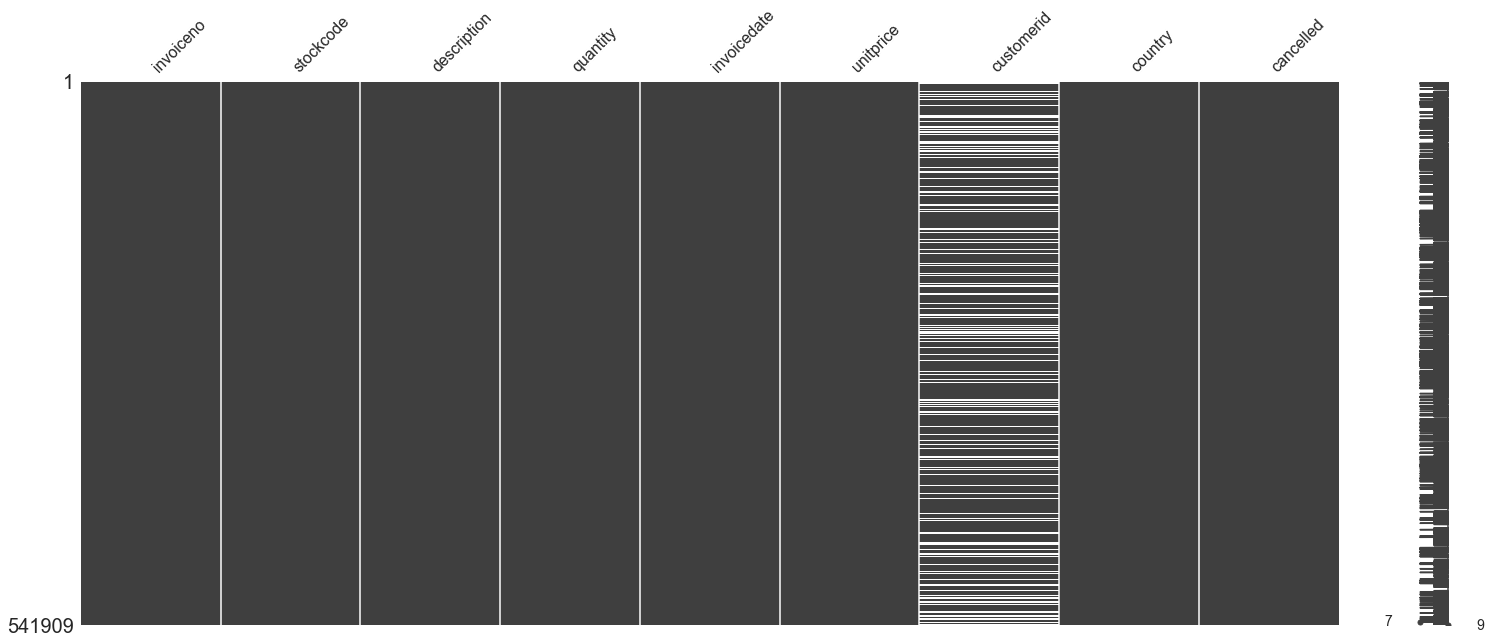

In [23]:
msno.matrix(dfc)
plt.show()

In [24]:
# total missing values 
print(f'There are {dfc.isna().sum().sum()} missing values')

# missing values by column 
dfc.isna().sum()

There are 136534 missing values


invoiceno           0
stockcode           0
description      1454
quantity            0
invoicedate         0
unitprice           0
customerid     135080
country             0
cancelled           0
dtype: int64

In [25]:
dfc.dropna(subset = ['description', 'customerid'], axis = 0, inplace = True)

In [26]:
# check
dfc.isna().sum()

invoiceno      0
stockcode      0
description    0
quantity       0
invoicedate    0
unitprice      0
customerid     0
country        0
cancelled      0
dtype: int64

#### Drop cancelled transactions, transactions where the unitprice is <= 0, transactions where quantity <= 0  

In [27]:
dfc = dfc[(dfc['cancelled'] == 0) & (dfc['unitprice'] > 0) & (dfc['quantity'] > 0)]

#### Finally, drop absolute duplicates

In [28]:
# check for customerid duplicates and transaction duplicates
print(f"There are {dfc['customerid'].duplicated().sum()} repeat orders")
print(f'There are {dfc.duplicated().sum()} duplicates')

There are 393546 repeat orders
There are 5192 duplicates


In [29]:
dfc.drop_duplicates(inplace = True)

In [30]:
print(f'There are {dfc.duplicated().sum()} duplicates')
print(f'Dataset has {dfc.shape[0]} rows and {dfc.shape[1]} columns')

There are 0 duplicates
Dataset has 392692 rows and 9 columns


In [31]:
# Check stats for dfc

print(dfc.info())
dfc.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    392692 non-null  object        
 1   stockcode    392692 non-null  object        
 2   description  392692 non-null  object        
 3   quantity     392692 non-null  int64         
 4   invoicedate  392692 non-null  datetime64[ns]
 5   unitprice    392692 non-null  float64       
 6   customerid   392692 non-null  float64       
 7   country      392692 non-null  object        
 8   cancelled    392692 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.0+ MB
None


,count,mean,std,min,25%,50%,75%,max
quantity,392692.0,13.119702,180.492832,1.000,2.00,6.00,12.00,80995.00
unitprice,392692.0,3.125914,22.241836,0.001,1.25,1.95,3.75,8142.75
customerid,392692.0,15287.843865,1713.539549,12346.000,13955.00,15150.00,16791.00,18287.00
cancelled,392692.0,0.000000,0.000000,0.000,0.00,0.00,0.00,0.00


<a id = 'creating'></a>
## 4.5 Creating new variables  
 
#### General notes
* Get invoicedates grouped by customers
* Extract first transaction period
* Calculate time offset in days
* Calculate total value
* Generate cohort tables: retention, price, quantity  

[back to top](#table_of_contents)

#### Create a invoicedatetime column

In [32]:
dfc['invoicedatetime'] = dfc['invoicedate']

#### Create a totalvalue column

In [33]:
dfc['totalvalue'] = dfc['unitprice'] * dfc['quantity']

In [34]:
# Define a function that will parse the dates 
def get_date(x): return dt.datetime(x.year, x.month, x.day)

# Define a function to extract the time from the datetime value
def get_time(x): return dt.time(x.hour, x.minute)

In [35]:
dfc['invoicedate'] = dfc['invoicedatetime'].apply(get_date)
dfc['invoicetime'] = dfc['invoicedatetime'].apply(get_time)

In [36]:
# time difference of about a year, which is compatible for a monthly cohort analysis > ~12 cohorts
print(f'Earliest date: {dfc["invoicedate"].dt.date.min()}')
print(f'Latest date: {dfc["invoicedate"].dt.date.max()}')
dfc['invoicedate'].value_counts().sort_index().head(10)

Earliest date: 2010-12-01
Latest date: 2011-12-09


2010-12-01    1898
2010-12-02    1959
2010-12-03    1086
2010-12-05    2602
2010-12-06    1897
2010-12-07    1094
2010-12-08    1909
2010-12-09    1739
2010-12-10    1358
2010-12-12    1380
Name: invoicedate, dtype: int64

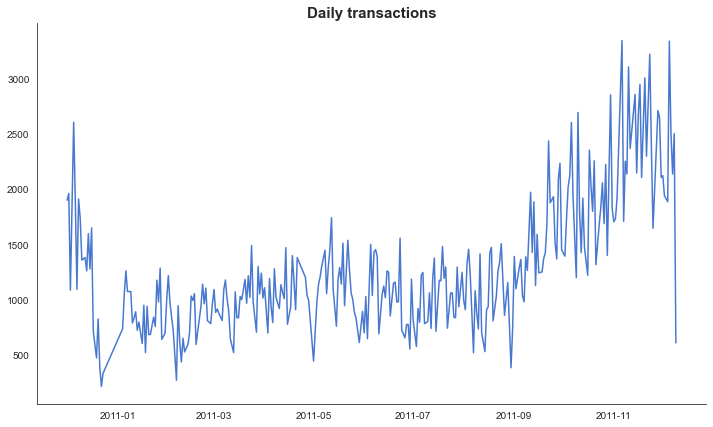

In [37]:
# Plot of daily transactions
daily_transactions = dfc['invoicedate'].value_counts().sort_index()
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.lineplot(x = daily_transactions.index, y = daily_transactions.values, ax = ax) 
plt.title('Daily transactions', fontsize = 15, fontweight = 'bold')
sns.despine()
plt.show()

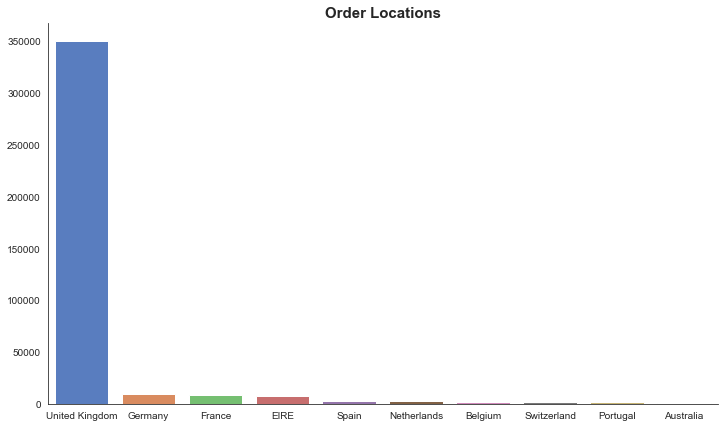

In [38]:
countries_10 = dfc['country'].value_counts().nlargest(10)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

sns.barplot(x=countries_10.index, y=countries_10.values, ax=ax)
plt.title('Order Locations', fontsize = 15, fontweight = 'bold')
sns.despine()
plt.show()

In [39]:
dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,392692.0,13.119702,180.492832,1.000,2.00,6.00,12.00,80995.00
unitprice,392692.0,3.125914,22.241836,0.001,1.25,1.95,3.75,8142.75
customerid,392692.0,15287.843865,1713.539549,12346.000,13955.00,15150.00,16791.00,18287.00
cancelled,392692.0,0.000000,0.000000,0.000,0.00,0.00,0.00,0.00
totalvalue,392692.0,22.631500,311.099224,0.001,4.95,12.45,19.80,168469.60


In [40]:
def get_month(x): return dt.datetime(x.year, x.month, 1)

dfc['invoicemonth'] = dfc['invoicedate'].apply(get_month)

In [41]:
# extract first transaction period: cohort join date
groupings = dfc.groupby('customerid')['invoicemonth']
dfc['cohortdate'] = groupings.transform('min')
dfc.head(10)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,cancelled,invoicedatetime,totalvalue,invoicetime,invoicemonth,cohortdate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,0,2010-12-01 08:26:00,15.30,08:26:00,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,0,2010-12-01 08:26:00,20.34,08:26:00,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,0,2010-12-01 08:26:00,22.00,08:26:00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,0,2010-12-01 08:26:00,20.34,08:26:00,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,0,2010-12-01 08:26:00,20.34,08:26:00,2010-12-01,2010-12-01
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01,7.65,17850.0,United Kingdom,0,2010-12-01 08:26:00,15.30,08:26:00,2010-12-01,2010-12-01
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01,4.25,17850.0,United Kingdom,0,2010-12-01 08:26:00,25.50,08:26:00,2010-12-01,2010-12-01
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01,1.85,17850.0,United Kingdom,0,2010-12-01 08:28:00,11.10,08:28:00,2010-12-01,2010-12-01
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01,1.85,17850.0,United Kingdom,0,2010-12-01 08:28:00,11.10,08:28:00,2010-12-01,2010-12-01
24,536368,22914,BLUE COAT RACK PARIS FASHION,3,2010-12-01,4.95,13047.0,United Kingdom,0,2010-12-01 08:34:00,14.85,08:34:00,2010-12-01,2010-12-01


In [42]:
# define a function to return the date components as integers
def get_date_int(df, col): 
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    return year, month, day

In [43]:
inv_year, inv_month, _ = get_date_int(dfc, 'invoicemonth')
coh_year, coh_month, _ = get_date_int(dfc, 'cohortdate')

#### We can calculate the months offset since the first transaction of each customer to arrive at the cohort 

In [44]:
# Calculate year difference
year_diff = inv_year - coh_year

# Calculate month difference
month_diff = inv_month - coh_month

# Calculate the total time difference in days 
dfc['cohortindex'] = year_diff * 12 + month_diff + 1

dfc.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,cancelled,invoicedatetime,totalvalue,invoicetime,invoicemonth,cohortdate,cohortindex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,0,2010-12-01 08:26:00,15.30,08:26:00,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,0,2010-12-01 08:26:00,20.34,08:26:00,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,0,2010-12-01 08:26:00,22.00,08:26:00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,0,2010-12-01 08:26:00,20.34,08:26:00,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,0,2010-12-01 08:26:00,20.34,08:26:00,2010-12-01,2010-12-01,1


<a id = 'retention'></a>
## 4.6 Calculate Absolute Cohorts and Retention 

[back to top](#table_of_contents)

In [45]:
# Count monthly active customers from each cohort 

grouping = dfc.groupby(['cohortdate', 'cohortindex'])
cohort_data = grouping['customerid'].apply(pd.Series.nunique)

display(cohort_data.head())

# Pivot by cohortdate and cohortindex to get the number of unique customers that made a purchase by cohort
cohort_data = cohort_data.reset_index()
absolutes = cohort_data.pivot(index = 'cohortdate', columns = 'cohortindex', values = 'customerid')

# Absolute unique customers 
absolutes

cohortdate  cohortindex
2010-12-01  1              885
            2              324
            3              286
            4              340
            5              321
Name: customerid, dtype: int64

cohortindex,1,2,3,4,5,6,7,8,9,10,11,12,13
cohortdate,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Extract the values from the first column 
cohort_sizes = absolutes.iloc[:, 0]
retention = absolutes.divide(cohort_sizes, axis = 0).round(3)*100

retention = retention.round(1)
retention.index = retention.index.date

retention

cohortindex,1,2,3,4,5,6,7,8,9,10,11,12,13
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,100.0,23.4,30.1,11.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id = 'price'></a>
## 4.7 Calculating Average Cohort Price

[back to top](#table_of_contents)

In [47]:
# Groupby cohortdate and cohortindex
grouping = dfc.groupby(['cohortdate', 'cohortindex']) 

# Calculate the unitprice average and reset index
cohort_data = grouping['unitprice'].mean()
cohort_data = cohort_data.reset_index()

# Create a price pivot 
price = cohort_data.pivot(index = 'cohortdate', columns = 'cohortindex', values = 'unitprice')
price = price.round(1)
price.index = price.index.date

price

cohortindex,1,2,3,4,5,6,7,8,9,10,11,12,13
2010-12-01,3.1,3.1,3.0,3.3,2.9,3.8,3.0,2.8,3.0,2.8,3.2,2.8,2.7
2011-01-01,3.2,3.5,3.0,5.8,3.1,3.1,2.9,2.7,2.6,4.2,2.8,2.5,NaN
2011-02-01,3.3,3.9,3.8,3.1,2.9,2.8,2.8,3.2,2.9,2.9,3.2,NaN,NaN
2011-03-01,3.3,4.2,3.4,3.2,3.0,2.7,2.8,2.8,2.7,2.4,NaN,NaN,NaN
2011-04-01,3.4,3.7,3.3,2.7,2.9,2.9,2.9,2.8,2.6,NaN,NaN,NaN,NaN
2011-05-01,3.9,3.0,2.6,3.0,2.7,2.5,2.6,2.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,3.5,2.8,3.3,2.8,2.6,3.1,2.4,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,3.0,3.3,2.7,2.7,2.4,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,3.0,4.6,4.9,5.8,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,3.2,3.3,2.9,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id = 'quantity'></a>
## 4.8 Calculating Average Cohort Quantity

[back to top](#table_of_contents)

In [48]:
grouping = dfc.groupby(['cohortdate', 'cohortindex'])
cohort_data = grouping['quantity'].mean()
cohort_data = cohort_data.reset_index()

# Create the quantity pivot table 
quantity = cohort_data.pivot(index = 'cohortdate', columns = 'cohortindex', values = 'quantity')
quantity = quantity.round()
quantity.index = quantity.index.date

quantity

cohortindex,1,2,3,4,5,6,7,8,9,10,11,12,13
2010-12-01,12.0,16.0,16.0,16.0,14.0,15.0,16.0,16.0,18.0,18.0,19.0,14.0,15.0
2011-01-01,17.0,13.0,13.0,15.0,13.0,15.0,15.0,15.0,12.0,11.0,10.0,10.0,NaN
2011-02-01,11.0,14.0,19.0,12.0,12.0,12.0,14.0,13.0,11.0,12.0,13.0,NaN,NaN
2011-03-01,10.0,12.0,13.0,10.0,14.0,13.0,13.0,14.0,11.0,10.0,NaN,NaN,NaN
2011-04-01,10.0,10.0,10.0,12.0,12.0,9.0,10.0,10.0,8.0,NaN,NaN,NaN,NaN
2011-05-01,11.0,10.0,14.0,13.0,11.0,9.0,11.0,114.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,11.0,15.0,11.0,14.0,11.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,10.0,14.0,7.0,8.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,10.0,6.0,5.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,12.0,6.0,8.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id = 'eda'></a>
## 5. Cohort Analysis Visualization  

#### We can visualize the generated cohort tables using heatmaps to aid interpretability
* Retention: the Dec-2010 cohort shows good retention over the rest, typical retention rates after a few months seems to be in the range of 18 - 24%
* Price: We can see that the Aug-2011 cohort seemed to experience a spike in average price - possibly due to the product mix
* Quantity: later cohorts don't seem to perform as well in terms of quantity - it is possible that they could be buying more expensive items

[back to top](#table_of_contents)

In [49]:
# define a plotting function 
def plot_table(df, vmin = 0, vmax = 10, cmap = 'Blues', title = ''):

    fig = plt.figure()
    gs = fig.add_gridspec(1, 1)
    ax0 = fig.add_subplot(gs[0, 0])

    sns.heatmap(df, ax = ax0, 
                annot = True, annot_kws = {'fontsize': 11},
                square = False, cbar = True, 
                vmin = vmin, vmax = vmax, 
                cmap = cmap, fmt = 'g')

    locals()['ax0'].set_title(f'{title}\n', fontsize = 15, fontweight = 'bold')
    locals()['ax0'].set_xlabel('')
    locals()['ax0'].set_ylabel('')
    locals()['ax0'].set_xticklabels(labels = df.columns, fontsize = 11)
    locals()['ax0'].set_yticklabels(labels = df.index, fontsize = 11)

    plt.show()

# define unique palettes for each 
cmap_r = sns.diverging_palette(22, 80, s = 70, l = 70, as_cmap = True)
cmap_p = sns.diverging_palette(22, 150, s = 80, l = 55, as_cmap = True)
cmap_q = sns.diverging_palette(22, 219, s = 80, l = 55, as_cmap = True)

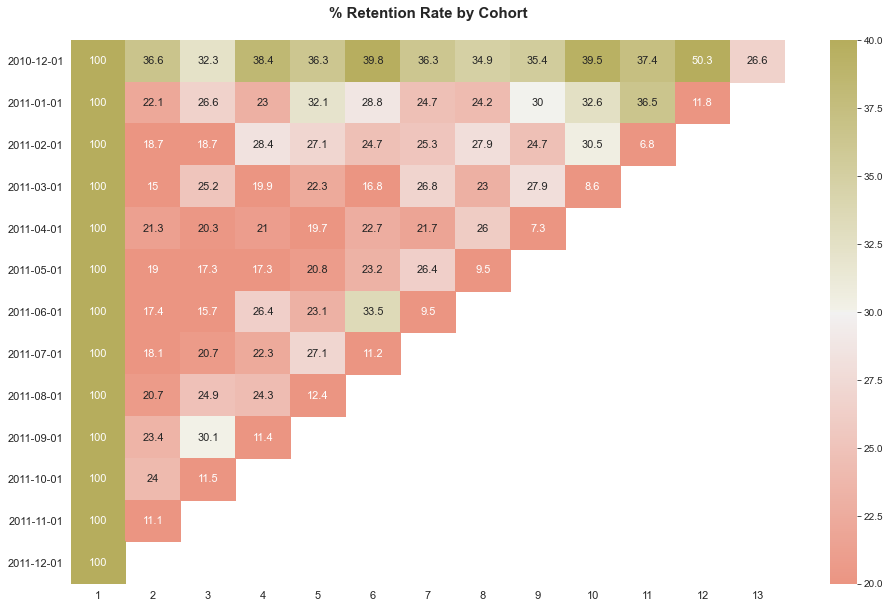

In [50]:
# Retention 
plot_table(retention, vmin = 20, vmax = 40, cmap = cmap_r, title = '% Retention Rate by Cohort')

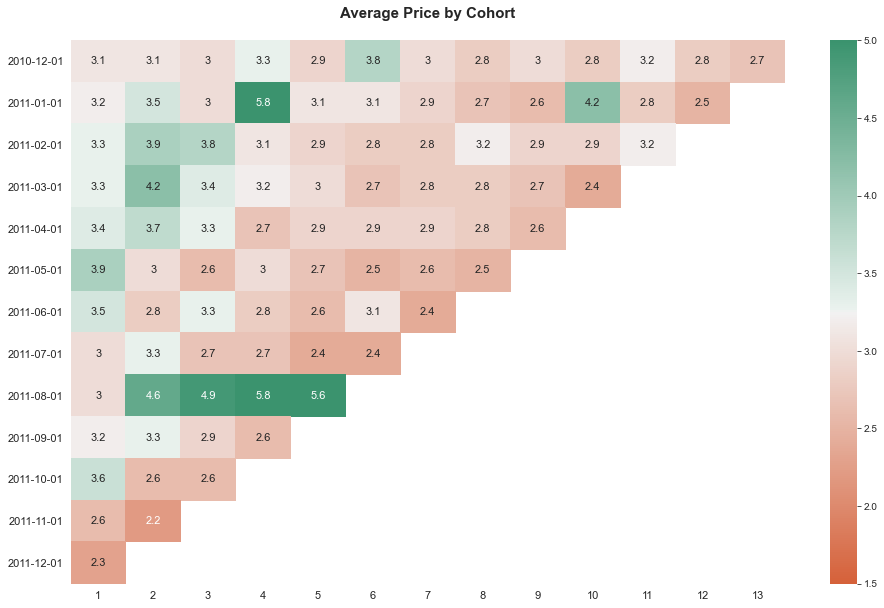

In [51]:
# Price 
plot_table(price, vmin = 1.5, vmax = 5, cmap = cmap_p, title = 'Average Price by Cohort')

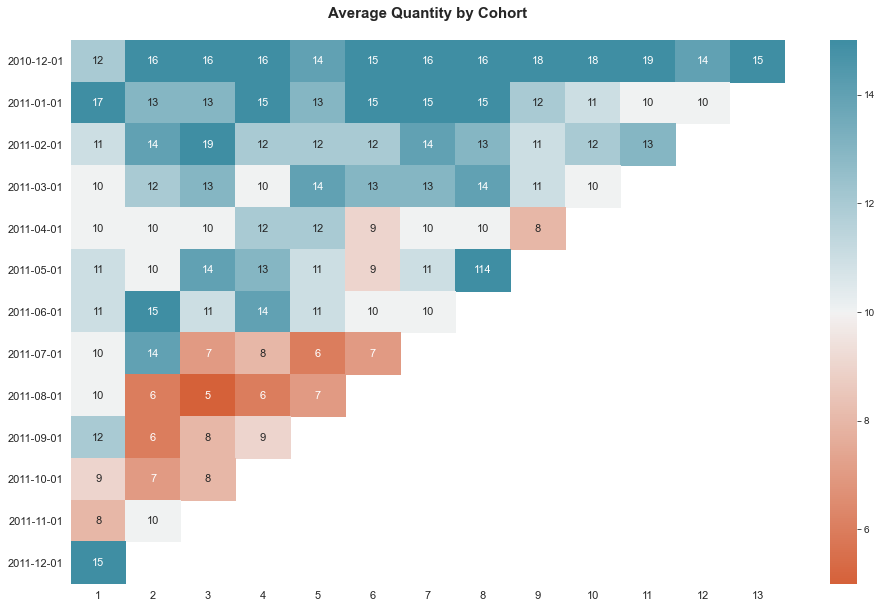

In [52]:
# Quantity 
plot_table(quantity, vmin = 5, vmax = 15, cmap = cmap_q, title = 'Average Quantity by Cohort')

<a id = 'rfm'></a>
## 6. RFM Analysis 

* RFM is an acronym of recency, frequency and monetary. Recency is about when was the last order of a customer. It means the number of days since a customer made the last purchase.

* Frequency is about the number of purchase in a given period. The larger the frequency, the more engaged the customers are. Combined with monetary value, frequency metrics give us a good idea of the value of the customer.

* Monetary is the total amount of money a customer spent in that given period. Therefore big spenders will be differentiated with other customers

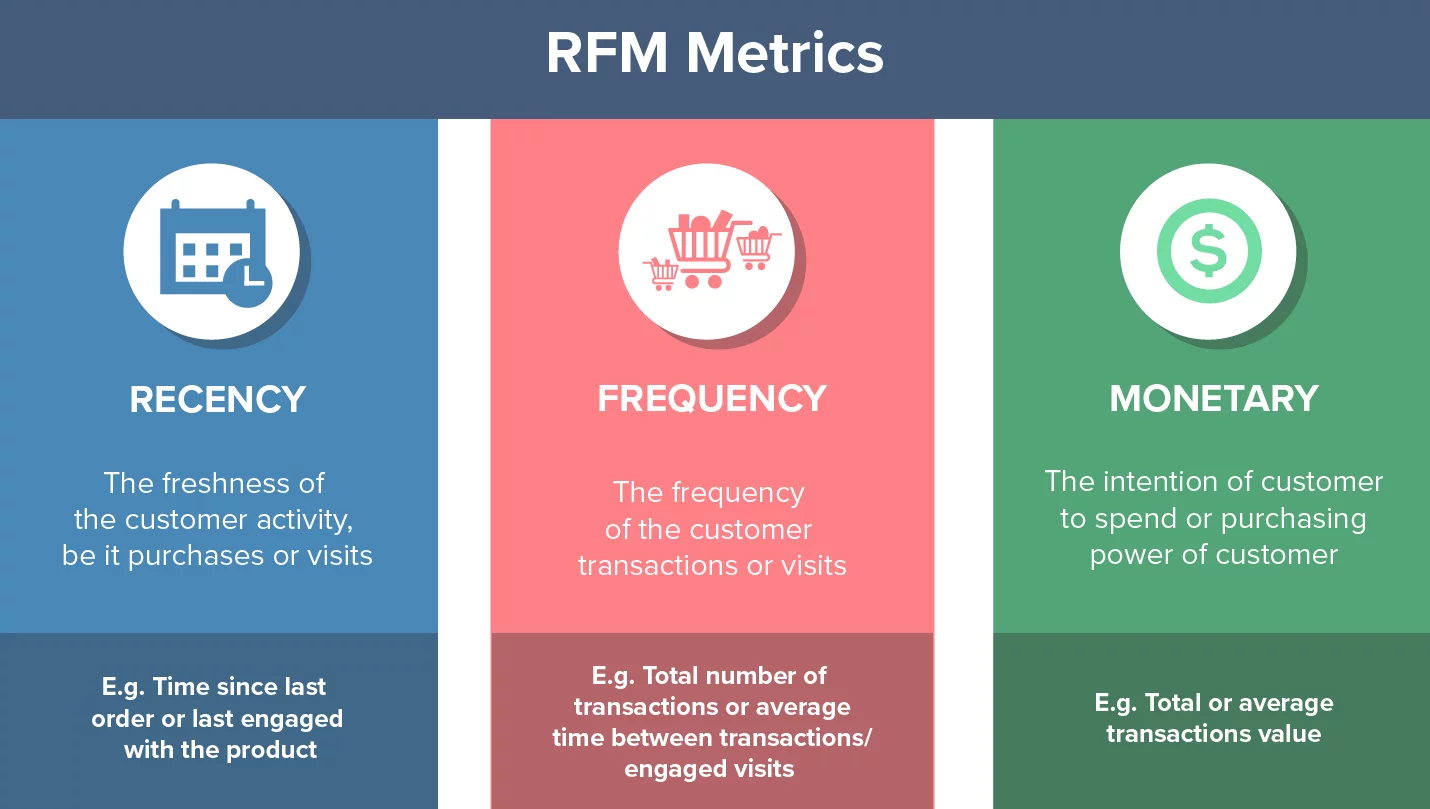

[back to top](#table_of_contents)

#### For the purposes of this analysis, we will define RFM as the following: 
* Recency – time since the last customer transaction
* Frequency – number of purchases in the observed period
* Monetary value – total amount spent in the observed period

#### Process of calculating percentiles:

* Sort customers based on that metric
* Break customers into a pre-defined number of groups of equal size
* Assign a label to each group

In [53]:
dfc.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,cancelled,invoicedatetime,totalvalue,invoicetime,invoicemonth,cohortdate,cohortindex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,0,2010-12-01 08:26:00,15.30,08:26:00,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,0,2010-12-01 08:26:00,20.34,08:26:00,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,0,2010-12-01 08:26:00,22.00,08:26:00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,0,2010-12-01 08:26:00,20.34,08:26:00,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,0,2010-12-01 08:26:00,20.34,08:26:00,2010-12-01,2010-12-01,1


In [54]:
print(f'Earliest invoice date: {dfc["invoicedatetime"].dt.date.min()}')
print(f'Most recent invoice date: {dfc["invoicedatetime"].dt.date.max()}')

dfc.head()

Earliest invoice date: 2010-12-01
Most recent invoice date: 2011-12-09


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,cancelled,invoicedatetime,totalvalue,invoicetime,invoicemonth,cohortdate,cohortindex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,0,2010-12-01 08:26:00,15.30,08:26:00,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,0,2010-12-01 08:26:00,20.34,08:26:00,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,0,2010-12-01 08:26:00,22.00,08:26:00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,0,2010-12-01 08:26:00,20.34,08:26:00,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,0,2010-12-01 08:26:00,20.34,08:26:00,2010-12-01,2010-12-01,1


#### The last day of purchase is 9 Dec 2011; we can set the snapshot date as one day after the last to calculate the no. of days since last transaction

In [55]:
# Creating the snapshotdate
snapshotdate = df['invoicedate'].max() + dt.timedelta(days = 1)

snapshotdate

Timestamp('2011-12-10 12:50:00')

In [56]:
# Calculate RFM metrics
rfm = dfc.groupby(['customerid']).agg({'invoicedate': lambda x: (snapshotdate - x.max()).days,
                                       'invoiceno': 'count',
                                       'totalvalue': 'sum'})

rfm.rename(columns = {'invoicedate': 'recency', 
                      'invoiceno': 'frequency', 
                      'totalvalue': 'monetaryvalue'}, inplace = True)

# Resulting table is conducive for scoring and clustering 
rfm.head()

,recency,frequency,monetaryvalue
customerid,,,
12346.0,326,1,77183.60
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


<a id = 'rfm_scoring'></a>

## 6.1 RFM Scoring 

#### General Notes

* We will score lower recency values as better, since we want customers who have made a purchase not too long ago
* In contrast, we will score higher frequency and monetary values as better, since we want our customers to spend more money and visit more often

[back to top](#table_of_contents)

In [57]:
# Creating labels for RFM segments 
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

# Assign labels to percentile gropus 
r_groups = pd.qcut(rfm['recency'], q = 4, labels = r_labels)
f_groups = pd.qcut(rfm['frequency'], q = 4, labels = f_labels)
m_groups = pd.qcut(rfm['monetaryvalue'], q = 4, labels = m_labels)

# Create new columns in the rfm df
rfm = rfm.assign(r_group = r_groups.values, f_group = f_groups.values, m_group = m_groups.values)

# Calculate RFM score and profile 

def add_rfm(x): return str(int(x['r_group'])) + str(int(x['f_group'])) + str(int(x['m_group']))
rfm['rfm_profile'] = rfm.apply(add_rfm, axis = 1)
rfm['rfm_score'] = rfm[['r_group', 'f_group', 'm_group']].sum(axis = 1)

rfm.head()

,recency,frequency,monetaryvalue,r_group,f_group,m_group,rfm_profile,rfm_score
customerid,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6
12347.0,3,182,4310.00,4,4,4,444,12
12348.0,76,31,1797.24,2,2,4,224,8
12349.0,19,73,1757.55,3,3,4,334,10
12350.0,311,17,334.40,1,1,2,112,4


In [58]:
# Random checks to make sure that the groups are making sense 
print(rfm.loc[rfm['r_group'] == 1, 'recency'].mean())
print(rfm.loc[rfm['r_group'] == 4, 'recency'].mean())

print(rfm.loc[rfm['f_group'] == 1, 'frequency'].mean())
print(rfm.loc[rfm['f_group'] == 4, 'frequency'].mean())

print(rfm.loc[rfm['m_group'] == 1, 'monetaryvalue'].mean())
print(rfm.loc[rfm['m_group'] == 4, 'monetaryvalue'].mean())

247.39354838709679
8.810516772438802
9.045904590459045
261.6148148148148
178.03352995391705
6486.259337327188


<a id = 'rfm_profiling'></a>

## 6.2 RFM Profiling

#### General Notes
* We can create RFM levels from aggregating RFM profiles 
* We will investigate the size of the generated segments before utilizing them for targeting 
* In general, we want similar sized segments 

[back to top](#table_of_contents)

In [59]:
rfm.groupby(['rfm_profile']).size().sort_values(ascending = True).head()

rfm_profile
441    3
142    3
414    6
314    7
124    7
dtype: int64

#### Filtering by rfm profiles 

In [60]:
#Select bottom RFM segment "111" and view top 5 rows
rfm[rfm['rfm_profile'] == '111'].head()

,recency,frequency,monetaryvalue,r_group,f_group,m_group,rfm_profile,rfm_score
customerid,,,,,,,,
12353.0,205,4,89.00,1,1,1,111,3
12361.0,288,10,189.90,1,1,1,111,3
12401.0,304,5,84.30,1,1,1,111,3
12402.0,324,11,225.60,1,1,1,111,3
12441.0,367,11,173.55,1,1,1,111,3


#### RFM Levels 

In [61]:
rfm['rfm_level'] = pd.qcut(rfm['rfm_score'], q = 3, labels = ['low', 'middle', 'high'])

rfm.head()

,recency,frequency,monetaryvalue,r_group,f_group,m_group,rfm_profile,rfm_score,rfm_level
customerid,,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6,low
12347.0,3,182,4310.00,4,4,4,444,12,high
12348.0,76,31,1797.24,2,2,4,224,8,middle
12349.0,19,73,1757.55,3,3,4,334,10,high
12350.0,311,17,334.40,1,1,2,112,4,low


In [62]:
rfm.groupby('rfm_level').agg({'recency': 'mean',
                              'frequency': 'mean',
                              'monetaryvalue': ['mean', 'count']}).round(1)

recency frequency monetaryvalue      
             mean      mean          mean count
rfm_level                                      
low         166.9      18.4         411.8  1752
middle       64.4      57.0        1163.0  1325
high         20.6     225.9        5253.6  1261

#### Observations 

* Typically, if we have demographic data, we can find out what the profiles of our high rfm customers look like 
* Our high RFM segment (valuable customers) have a recency value of 20 days, an average transaction value of 5000, and average frequency of 225 items  

<a id = 'segmentation'></a>

## 7. Segmentation

#### We must ensure these key assumptions are met before we implement our K-Means algorithm:

* Symmetric distribution of variables (not skewed) - solution is to log-transform the variables  
* Variables with same average values and variance - solution is to standardize the variables 
* These assumptions can be check through the distplot / kdeplot 
* In the case of the ecommerce data, which is both skewed and of different scales, log-transformation must be done before scaling 
* The reason for this is that log-transformations only work with positive values

[back to top](#table_of_contents)

In [63]:
rfm_raw = rfm[['recency','frequency','monetaryvalue']]
rfm_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4338.0,93.059474,100.012264,1.00,18.0000,51.00,142.7500,374.00
frequency,4338.0,90.523744,225.506968,1.00,17.0000,41.00,98.0000,7676.00
monetaryvalue,4338.0,2048.688081,8985.230220,3.75,306.4825,668.57,1660.5975,280206.02


In [63]:
def rfm_kde(df): 
    fig = plt.figure(figsize = (16, 25))
    gs = fig.add_gridspec(len(df.columns), 1)
    gs.update(wspace = 0.2, hspace = 0.2)

    run = 0 

    for row in range(len(df.columns)):
        for col in range(1):
            locals()[f'ax{run}'] = fig.add_subplot(gs[row, col])
            locals()[f'ax{run}'].set_yticklabels([])
            locals()[f'ax{run}'].tick_params(axis = 'y', which = 'both', length = 0)
            for s in ['top', 'right', 'left']:
                locals()[f'ax{run}'].spines[s].set_visible(False)
            run += 1

    run = 0

    for col in df:
        sns.kdeplot(df[col], ax = locals()[f'ax{run}'], shade = True, linewidth = 0.5)
        locals()[f'ax{run}'].grid(which = 'major', axis = 'x', zorder = 0, color = 'black', linestyle = ':', dashes = (1,5))
        locals()[f'ax{run}'].set_title(col, fontsize = 15, fontweight = 'bold')
        locals()[f'ax{run}'].set_xlim(df[col].min() - 2, df[col].max() + 2)
        locals()[f'ax{run}'].set_xlabel('')
        locals()[f'ax{run}'].set_ylabel('')
        run += 1

    plt.show()

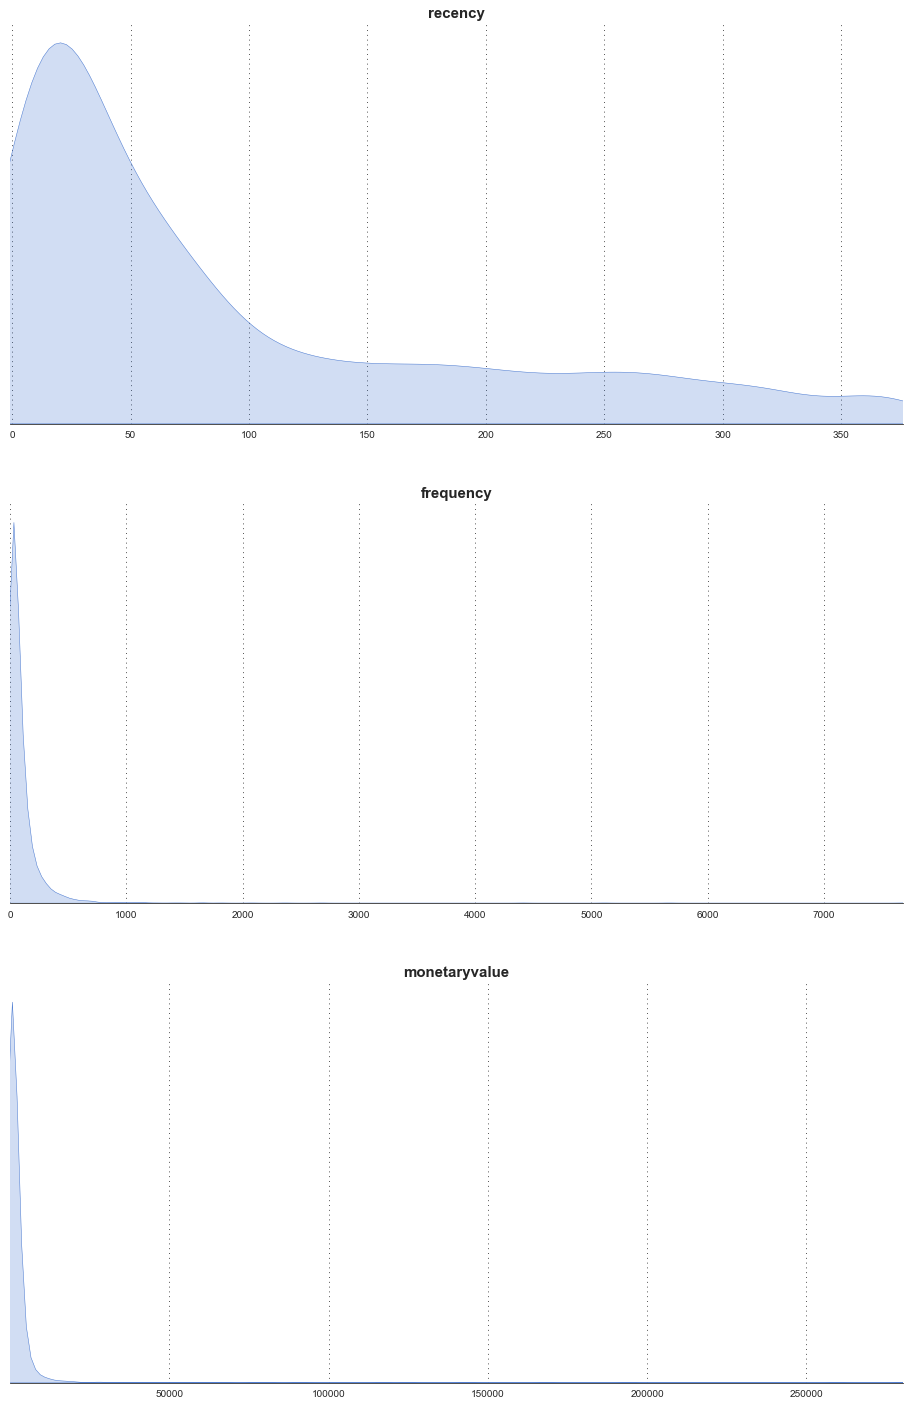

In [64]:
rfm_kde(rfm_raw)

In [65]:
# Unskew the data with np.log
rfm_log = np.log(rfm_raw)

rfm_log

,recency,frequency,monetaryvalue
customerid,,,
12346.0,5.786897,0.000000,11.253942
12347.0,1.098612,5.204007,8.368693
12348.0,4.330733,3.433987,7.494007
12349.0,2.944439,4.290459,7.471676
12350.0,5.739793,2.833213,5.812338
...,...,...,...
18280.0,5.627621,2.302585,5.196285
18281.0,5.198497,1.945910,4.392224
18282.0,2.079442,2.484907,5.182064


In [66]:
# Normalize the variables with StandardScaler
scaler = StandardScaler()

rfm_log_norm = scaler.fit_transform(rfm_log)

In [67]:
rfm_log_norm = pd.DataFrame(rfm_log_norm, columns = rfm_raw.columns, index = rfm_raw.index)

rfm_log_norm

,recency,frequency,monetaryvalue
customerid,,,
12346.0,1.435416,-2.779978,3.700201
12347.0,-1.953393,1.160356,1.413256
12348.0,0.382865,-0.179855,0.719951
12349.0,-0.619183,0.468643,0.702251
12350.0,1.401368,-0.634745,-0.612996
...,...,...,...
18280.0,1.320288,-1.036522,-1.101300
18281.0,1.010106,-1.306587,-1.738625
18282.0,-1.244425,-0.898473,-1.112572


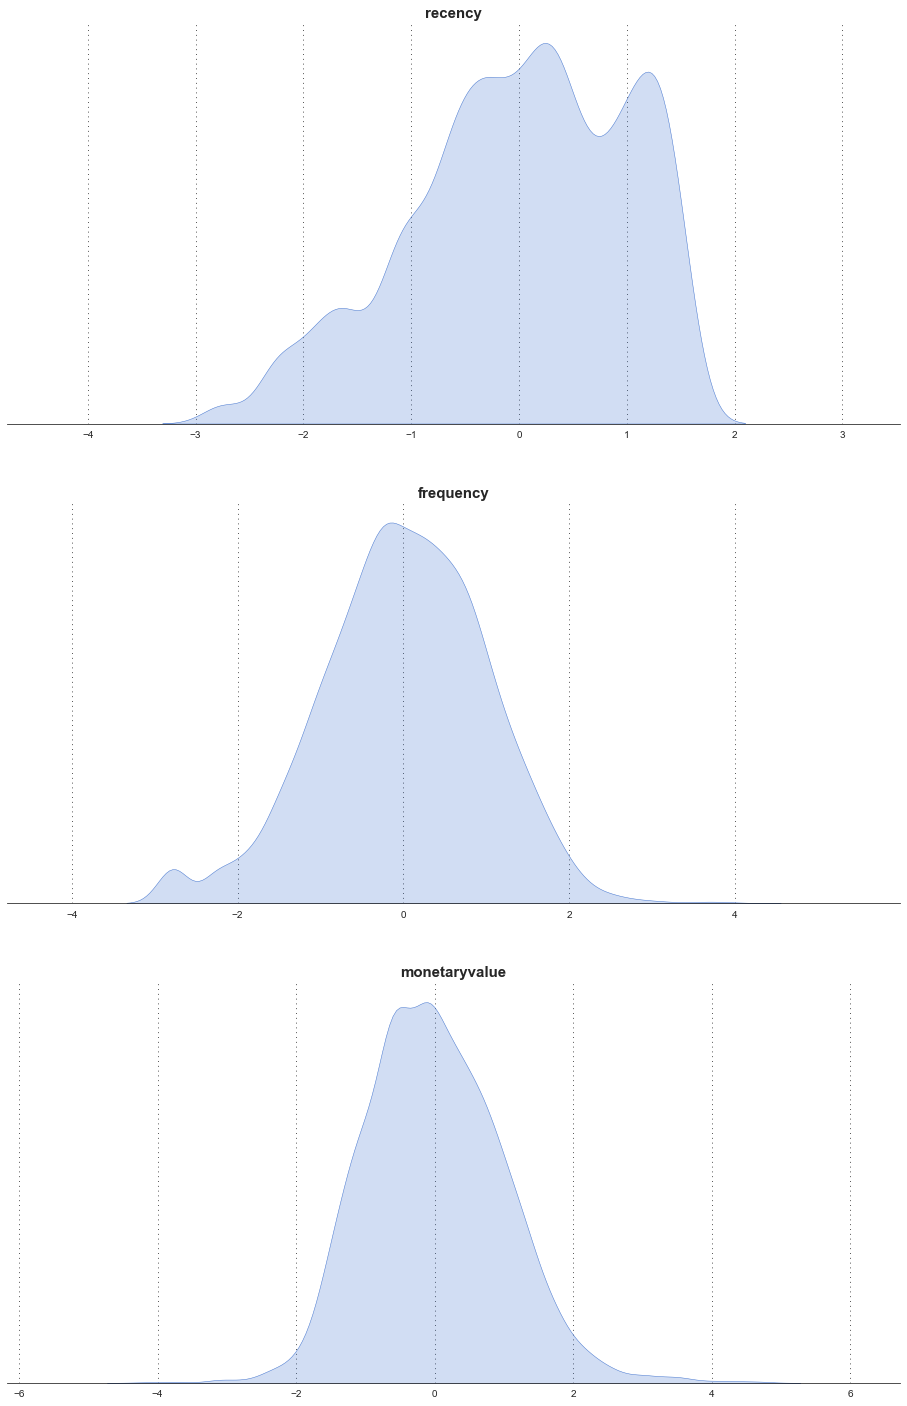

In [68]:
# Check the distributions of the rfm variables 
rfm_kde(rfm_log_norm)


#### The results more closely appromixate a normal distribution now

<a id = 'kmeans'></a>

## 7.1 K-Means Clustering and Visualization¶

#### Key steps

* Data pre-processing
* Choosing a number of clusters
* Running k-means clustering on pre-processed data
* Analyzing average RFM values of each cluster

[back to top](#table_of_contents)

<a id = 'choosing_k'></a>

## 7.2 Choosing K

#### Methods to define the number of clusters

* Visual confirmation using the scree plot - identify the elbow break to determine ideal n_clusters

    - Plot the number of clusters against within-cluster sum-of-squared-errors (SSE) - sum of squared distances from every data point to their cluster center
    - Identify an "elbow" in the plot
    - Elbow - a point representing the "optimal" number of clusters
* Mathematically using the silhouette coefficient


[back to top](#table_of_contents)

In [69]:
# Instantiate multiple values of K and record their within-cluster SSEs 
K = list(range(1, 10))
sse = {}

for k in K:
    # Create a KMeans trainer
    kmeans = KMeans(n_clusters = k, random_state = 123)
    kmeans.fit(rfm_log_norm)
    sse[k] = kmeans.inertia_

<a id = 'screeplot'></a>

## 7.3 Scree Plot

[back to top](#table_of_contents)

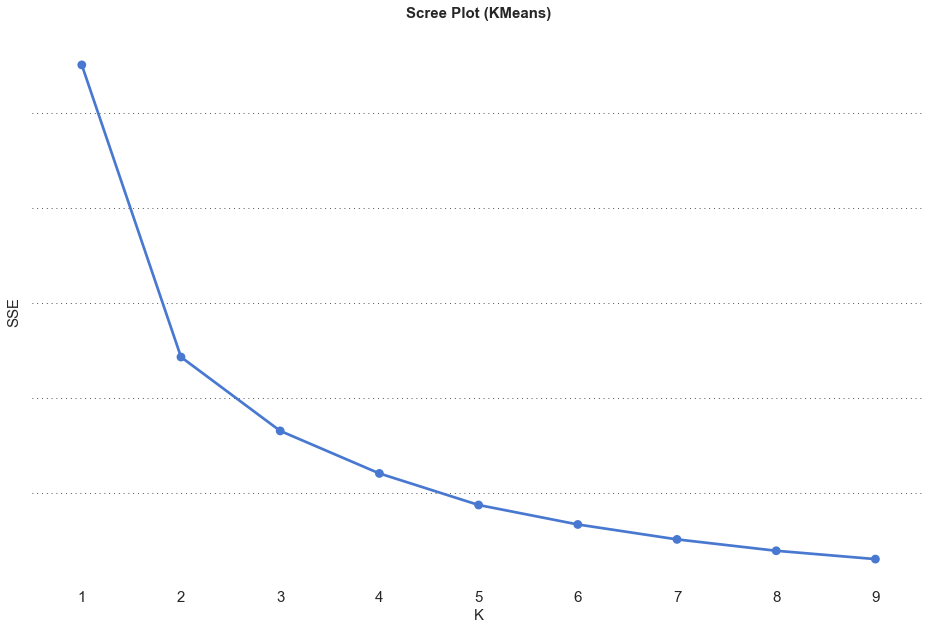

In [70]:
fig = plt.figure()
gs = fig.add_gridspec(1, 1)
ax0 = fig.add_subplot(gs[0, 0])

for s in ['top', 'right', 'left', 'bottom']: 
    ax0.spines[s].set_visible(False)

sns.pointplot(x = list(sse.keys()), y = list(sse.values()), ax = ax0, color = col_blue)

ax0.set_title('Scree Plot (KMeans)\n', fontsize = 15, fontweight = 'bold')

ax0.set_xlabel('K', fontsize = 15)
ax0.set_ylabel('SSE', fontsize = 15)
ax0.set_xticklabels(K, fontsize = 15)
ax0.set_yticklabels('')

ax0.grid(which = 'major', axis = 'y', zorder = 0, color = 'black', linestyle = ':', dashes = (1,5))

plt.show()

<a id = 'k_clusters'></a>

## 7.4 K-Means Clusters

From the scree plot, 3 and 4 seem to be good candidates for k 

[back to top](#table_of_contents)

In [71]:
# Selection of k for clustering: 3

kmeans3 = KMeans(n_clusters = 3, random_state = 123)
kmeans3.fit(rfm_log_norm)

cluster_labels = kmeans3.labels_

rfm_k3 = rfm.assign(k_cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_k3.groupby('k_cluster').agg({'recency': 'mean',
                                 'frequency': 'mean',
                                 'monetaryvalue': ['mean', 'count']}).round(0)

recency frequency monetaryvalue      
             mean      mean          mean count
k_cluster                                      
0           172.0      15.0         294.0  1524
1            69.0      65.0        1158.0  1854
2            14.0     260.0        6555.0   960

<a id = 'snake_plots'></a>

## 7.5 Snake Plots

* Snake plots are a market research technique to compare different segments
* Visual representation of each segment's attributes
* Need to first normalize data (center & scale)
* After normalizing, we will plot each cluster's average normalized values for each attribute

[back to top](#table_of_contents)

In [72]:
rfm_snake = pd.DataFrame(rfm_log_norm, columns = rfm_log_norm.columns, index = rfm_log_norm.index)
rfm_snake['k_cluster'] = kmeans3.labels_
rfm_snake = rfm_snake.assign(rfm_level = rfm['rfm_level'])
rfm_snake = rfm_snake.reset_index()

rfm_snake

,customerid,recency,frequency,monetaryvalue,k_cluster,rfm_level
0,12346.0,1.435416,-2.779978,3.700201,1,low
1,12347.0,-1.953393,1.160356,1.413256,2,high
2,12348.0,0.382865,-0.179855,0.719951,1,middle
3,12349.0,-0.619183,0.468643,0.702251,1,high
4,12350.0,1.401368,-0.634745,-0.612996,0,low
...,...,...,...,...,...,...
4333,18280.0,1.320288,-1.036522,-1.101300,0,low
4334,18281.0,1.010106,-1.306587,-1.738625,0,low
4335,18282.0,-1.244425,-0.898473,-1.112572,0,low
4336,18283.0,-1.745449,2.202705,0.822522,2,high


In [73]:
# Melt the data into a long format
rfm_snake = pd.melt(rfm_snake, id_vars = ['customerid', 'rfm_level', 'k_cluster'], 
                    value_vars = ['recency', 'frequency', 'monetaryvalue'],
                    var_name = 'metric', value_name = 'value')

rfm_snake

,customerid,rfm_level,k_cluster,metric,value
0,12346.0,low,1,recency,1.435416
1,12347.0,high,2,recency,-1.953393
2,12348.0,middle,1,recency,0.382865
3,12349.0,high,1,recency,-0.619183
4,12350.0,low,0,recency,1.401368
...,...,...,...,...,...
13009,18280.0,low,0,monetaryvalue,-1.101300
13010,18281.0,low,0,monetaryvalue,-1.738625
13011,18282.0,low,0,monetaryvalue,-1.112572
13012,18283.0,high,2,monetaryvalue,0.822522


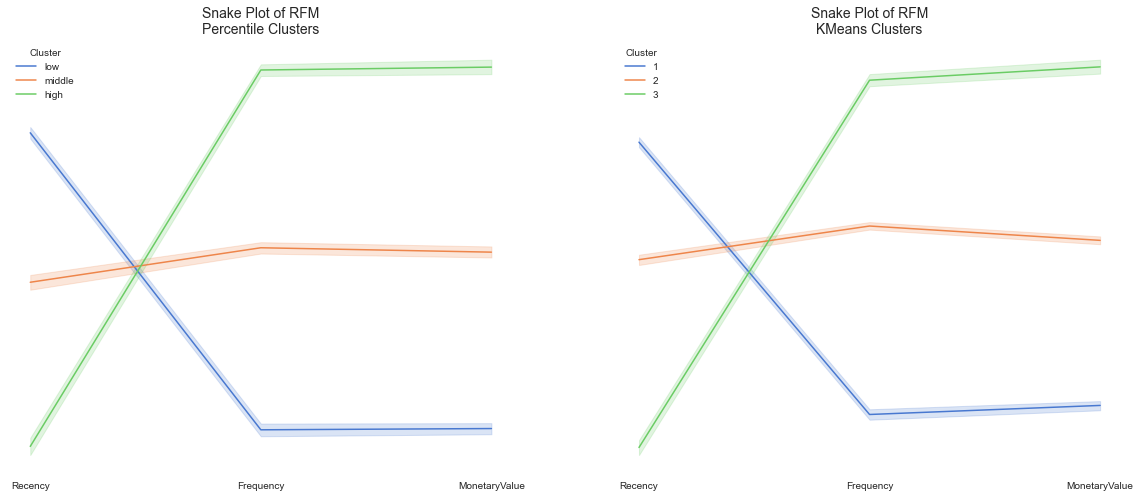

In [74]:
fig = plt.figure(figsize = (20, 8))
gs = fig.add_gridspec(1, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

for s in ['top', 'right', 'left', 'bottom']: 
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)

sns.lineplot(x = 'metric', y = 'value', hue = 'rfm_level', data = rfm_snake, ax = ax0, palette = 'muted')

# a snake plot with K-Means
sns.lineplot(x = 'metric', y = 'value', hue = 'k_cluster', data = rfm_snake, ax = ax1, palette = 'muted')

run = 0

for _ in range(2): 
    locals()[f'ax{run}'].legend(title = 'Cluster', frameon = False)
    locals()[f'ax{run}'].set_xlabel('')
    locals()[f'ax{run}'].set_ylabel('')
    locals()[f'ax{run}'].set_xticks(np.arange(3))
    locals()[f'ax{run}'].set_xticklabels(labels = ['Recency', 'Frequency', 'MonetaryValue'])
    locals()[f'ax{run}'].set_yticklabels('')
    run += 1

locals()['ax0'].set_title('Snake Plot of RFM\nPercentile Clusters', fontsize = 14)
locals()['ax1'].set_title('Snake Plot of RFM\nKMeans Clusters', fontsize = 14)
locals()['ax1'].legend(labels = [1, 2, 3], title = 'Cluster', frameon=False)

plt.show()

#### The KMeans clusters are very similar to the results from RFM profiling - the high RFM level appears to correspond to cluster 3

<a id = 'importance'></a>

## 7.6 Importance Scores

* Importance scores are useful to determine the relative importance of each segment's attribute
* Calculate average values of each cluster
* Calculate average values of population
* Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)
* Visualize using a heatmap

[back to top](#table_of_contents)

In [75]:
cluster_avg = rfm_k3.groupby(['k_cluster'])[['recency', 'frequency', 'monetaryvalue']].mean()
pop_avg = rfm_k3[['recency','frequency', 'monetaryvalue']].mean()

importance = cluster_avg / pop_avg - 1
importance = importance.round(1)

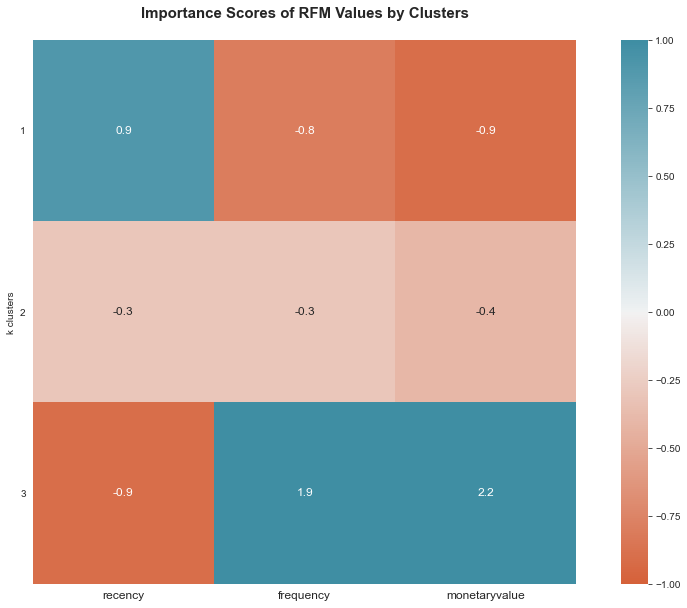

In [76]:
fig = plt.figure()
gs = fig.add_gridspec(1, 1)
ax0 = fig.add_subplot(gs[0, 0])

sns.heatmap(importance, ax = ax0, 
            annot = True, annot_kws = {'fontsize': 12},
            square = True, cbar = True, 
            vmin = -1, vmax = 1, 
            cmap = cmap_q, fmt = 'g')

ax0.set_title('Importance Scores of RFM Values by Clusters\n', fontsize = 15, fontweight = 'bold')
ax0.set_xticklabels(importance.columns, fontsize = 12, rotation = 0)
ax0.set_ylabel('k clusters', rotation = 90)
ax0.set_yticklabels(labels = [1, 2, 3], rotation = 0)

plt.show()

#### High frequency and monetary value transactions are what are more important to defining our high value customers 

## Conclusion

#### We have explored RFM metrics from customer purchase data, and we made two kinds of segmentation with RFM quantiles and K-Means clustering methods

Next steps: 
* Exploring alternative groupings of k 
* Integrating existing dataset with demographic data to understand high value customers and their lifestyles for targetting
* Market Basket Analysis (MBA) of customers to find out which items are most frequently purchased together